# BERTweet fine-tuned + Torchmoji fusion classifier for sarcasm detection

Based on the notebook: https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/

In [1]:
# Fish for target GPU

import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


# Installs

In [2]:
!pip install transformers
!pip install emoji==0.6.0
!pip install numpy==1.21.5
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install scipy==1.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.0 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 70.2 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 4.1 MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49734 sha256=59cceec2c6c07a86e095aa9ce2873dca8a3bca3f3db1b66ef7bd9a2e7d30710a
  Stored in directory: /root/.cache/pip/wheels/4e/bf/6b/2e22b3708d14bf6384f862db539b044d6931bd6b14ad3c9adc
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 102.0 MB/s eta 0:00:13tcmalloc: large alloc 1147494400 bytes == 0x39b44000 @  0x7ff27c973615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████▉                | 1055.7 MB 1.1 MB/s eta 0:15:42tcmalloc: large alloc 1434370048 bytes == 0x7e19a000 @  0x7ff27c973615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 39 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# **Restart the runtime after installs!**

# Imports

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import emoji
   
from sklearn.metrics import precision_recall_curve # NEW

from transformers import AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
%matplotlib inline

# Check GPU for reproducibility

In [2]:
# setup GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


# Load dataset

In [3]:
training_data = pd.read_csv('/content/balanced_train_En_seed10.csv')
training_data

,Unnamed: 0,Unnamed: 0.1,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,341,341,@Dancruz07 Sureeeeeee you do,1,"I could've replied ""You do not despise me, you...",1.0,0.0,0.0,0.0,0.0,0.0
1,138,138,"@BoardroomBoy Few links for you. To summarise,...",1,"I would omit the ""who'da thunk"" part.",1.0,0.0,0.0,0.0,0.0,1.0
2,241,241,#bbcqt It sure would be nice if Ms May decided...,1,Theresa May just needs to answer the question.,1.0,0.0,0.0,0.0,0.0,0.0
3,1359,1359,Someone in Walmart asked my mom if I was a boy...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,588,588,Being a mom with an autoimmune disease means I...,1,I wouldn't because sarcasm is the only weapon ...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1557,1635,1635,i was so bored today that i let my computer re...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1558,2306,2306,It is midnight. On a Thursday. My roommates de...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1559,3149,3149,"when i was taken off anesthesia today, i told ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1560,1153,1153,@savingfilm @_celia_bedelia_ I have zero tampo...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
positive_augment_training_data = pd.read_csv('/content/sarcastic_all_no_hashtags.csv', lineterminator='\n')
positive_augment_training_data

,Unnamed: 0,Unnamed: 0.1,tweet,label
0,0,0,"@cityofdenver, been driving/sliding all around...",1
1,1,1,This. This is the news that matters: http://t....,1
2,2,2,"@empressivegeek LOL, you guys are lawyers righ...",1
3,3,3,The start of another super busy week. So pumped.,1
4,4,4,I'm gonna start knitting again.. Because it's ...,1
...,...,...,...,...
28023,28023,28006,@dangainor @SuePendleton2 @piersmorgan pahahah...,1
28024,28024,28007,@jennapoole11 wait till the game at White Hous...,1
28025,28025,28008,Well well I didn't know it was snowing with al...,1
28026,28026,28009,Just want to thank all of my friends for showi...,1


In [5]:
negative_augment_training_data = pd.read_csv('/content/negative_all.csv', lineterminator='\n')
negative_augment_training_data

,Unnamed: 0,Unnamed: 0.1,tweet,label
0,0,0,@ChrisGreenBean I thought you speak about a gu...,0
1,1,1,fancis moves into a different plane at age 32 ...,0
2,2,2,Elmer http://t.co/u8nP9vqu3Z via @comiXology O...,0
3,3,3,[needrestart] https://t.co/HlZA2TDymo Thomas L...,0
4,4,4,Webinar with Landatel for Spanish customers - ...,0
...,...,...,...,...
31747,31747,31747,@blingyeol we should! That'd be awesome :'3 I ...,0
31748,31748,31748,The Polaroid iM1836 copycat camera is now gone...,0
31749,31749,31749,"Woke up around 9, 20 min later smoke like is t...",0
31750,31750,31750,Czech glass beads handmade shamballa bracelet ...,0


In [6]:
validation_data = pd.read_csv('/content/balanced_validation_En_seed10.csv')
validation_data

,Unnamed: 0,Unnamed: 0.1,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,2708,2708,The meaning behind Little Talks - @monstersand...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3416,3416,Kyle is out of town so i made a baked ziti and...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3254,3254,Applying for jobs is so weird and feels fake,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,293,293,@lora__ SHOCKED. How am I supposed to tell the...,1,These people were aware of the risks when they...,1.0,0.0,0.0,0.0,0.0,0.0
4,1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
167,656,656,Is spunk a slur?,1,I am worried that I may have used a slur by sa...,0.0,1.0,0.0,0.0,0.0,1.0
168,1653,1653,OH MY GOD I AM IN LOVE WITH MY FIANCÉ. https:/...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,3074,3074,Just get yer jab and shut yer moof,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,43,43,"I suppose though, we did sign one for the futu...",1,I wish we could have signed a player for the f...,1.0,0.0,0.0,1.0,0.0,0.0


In [7]:
test_data = pd.read_csv('/content/task_A_En_test.csv')
test_data

,text,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0
...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,0
1396,Omg how an earth is that a pen !!! 🤡,0
1397,Bringing Kanye and drake to a tl near you,0
1398,"I love it when women are referred to as ""girl ...",1


In [8]:
# Set label to use in binary classifcation
LABEL_TO_CLASSIFY = 'sarcastic'

In [9]:
# Reduce the size of the augmentation data to to make processing faster

NUM_TO_SAMPLE = 800

sampled_positives = positive_augment_training_data.sample(n=NUM_TO_SAMPLE, random_state=4040)
sampled_negatives = negative_augment_training_data.sample(n=NUM_TO_SAMPLE, random_state=4040)

augment_training_data = pd.concat([sampled_positives, sampled_negatives]).reset_index(drop=True)

In [10]:
X_aug_train = augment_training_data['tweet'].astype('str')
y_aug_train = augment_training_data['label'].astype('int')

In [11]:
# Get training and validation input(X) and label(y) sets
X_train = training_data['tweet']
X_val = validation_data['tweet']

y_train = training_data[LABEL_TO_CLASSIFY]
y_val = validation_data[LABEL_TO_CLASSIFY]

# X_train = pd.concat([X_train, X_aug_train]).reset_index(drop=True)
# y_train = pd.concat([y_train, y_aug_train]).reset_index(drop=True)

In [12]:
X_test = test_data['text']
y_test = test_data['sarcastic']

# Define BERTweet preprocessing
BERTweet-large does not have pre-processing built into its huggingface tokenizer, so we have to do it ourselves here. This code is from: https://github.com/VinAIResearch/BERTweet/blob/master/TweetNormalizer.py

In [13]:
# Define preprocessing function for BERTweet-large (not needed for base version)

from nltk.tokenize import TweetTokenizer
from emoji import demojize

bertweet_preprocessing_tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = bertweet_preprocessing_tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

# Tokenize the BERTweet inputs
Normalization is set to false because we are doing it using the 'normalizeTweet' function above.

In [14]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", normalization=False, use_fast=False)

# Define function to do BERT family preprocessing
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/614 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]


Length of encoded posts:


count    1734.000000
mean       28.310265
std        15.434860
min         4.000000
25%        17.000000
50%        25.000000
75%        36.000000
max       105.000000
dtype: float64

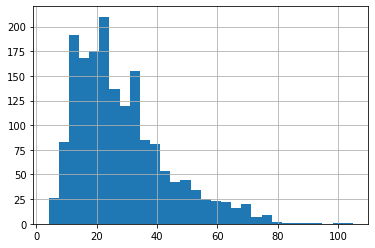

In [15]:
# Analyze post lengths after processing. This block is not required.

all_posts = pd.concat([training_data, validation_data])['tweet']

# all_posts = augment_training_data['text']

# preprocess tweets using BERTweet normalizer
all_posts = [normalizeTweet(sent) for sent in all_posts]

# Encode our concatenated data
encoded_posts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_posts]

# get length of all the messages in the train set
seq_len = [len(i) for i in encoded_posts]

print("\nLength of encoded posts:")
pd.Series(seq_len).hist(bins = 30)

pd.Series(seq_len).describe()

In [16]:
# Specify `MAX_LEN`
MAX_LEN = 100

# Print sentence 1 and its encoded token ids
normalized_example = normalizeTweet(X_train[0])
token_ids = list(preprocessing_for_bert([normalized_example])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Normalized tweet:', normalized_example)
print('Token IDs: ', token_ids)

# normalize all tweets for BERTweet
for index, value in X_train.iteritems():
  X_train.at[index] = normalizeTweet(value)
for index, value in X_val.iteritems():
  X_val.at[index] = normalizeTweet(value)

# Run function `preprocessing_for_bert` on the train set and the validation set
pretrain_inputs, pretrain_masks = preprocessing_for_bert(X_aug_train)
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  @Dancruz07 Sureeeeeee you do
Normalized tweet: @USER Sureeeeeee you do
Token IDs:  [0, 1039, 47955, 9136, 45835, 1942, 47, 109, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
for index, value in X_test.iteritems():
  X_test.at[index] = normalizeTweet(value)

test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create dataloaders

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

pretrain_labels = torch.tensor(y_aug_train.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our augment pretraining set
pretrain_data = TensorDataset(pretrain_inputs, pretrain_masks, pretrain_labels)
pretrain_sampler = RandomSampler(pretrain_data)
pretrain_dataloader = DataLoader(pretrain_data, sampler=pretrain_sampler, batch_size=batch_size)

# Create the DataLoaders for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoaders for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [19]:
test_labels = torch.tensor(y_test.values)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Define model class

In [20]:
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 1024, 100, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("vinai/bertweet-large")

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.33),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        bert_outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = bert_outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [21]:
def initialize_model(current_train_dataloader, epochs=5, learning_rate=1e-3):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=learning_rate,    # Default learning rate is 1e-3
                      eps=1e-8,    # Default epsilon value is 1e-6
                      weight_decay=.01
                      )
   
    # Total number of training steps
    total_steps = len(current_train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [22]:
def re_initialize_optimizer(current_train_dataloader, epochs=5, learning_rate=1e-3):
    
    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=learning_rate,    # Default learning rate is 1e-3
                      eps=1e-8,    # Default epsilon value is 1e-6
                      weight_decay=.01
                      )
    
    # Total number of training steps
    total_steps = len(current_train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return optimizer, scheduler

# Define training and evaluation loops

In [23]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """

    # set initial best positive F1 score to negative infinity
    best_pos_f1 = -float('inf')
    best_val_accuracy = -float('inf')
    best_epoch = 0

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)

        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, best_pos_eval_f1_score, best_threshold = evaluate(model, val_dataloader)

            #save the best model
            if best_pos_eval_f1_score > best_pos_f1:
                best_pos_f1 = best_pos_eval_f1_score
                best_epoch = epoch_i + 1
                torch.save(model.state_dict(), 'saved_weights.pt')

                # store best threshold in log file
                with open("best_threshold.txt", mode="w", newline="\n", encoding="utf-8") as output_file:
                  output_file.write(str(best_threshold))

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
            print('Best positive F1 score for current epoch:', best_pos_eval_f1_score, 'Best threshold:', best_threshold, 'Epoch of best model:', best_epoch)
        print("\n")
    
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    all_eval_logits = []

    # For each batch in our validation set...
    for batch in val_dataloader:      
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        all_eval_logits.append(logits.cpu())

        # Compute batch loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    # Concatenate logits from each batch
    all_eval_logits = torch.cat(all_eval_logits, dim=0)

    # Apply softmax to calculate probabilities
    all_probs = F.softmax(all_eval_logits, dim=1).cpu().numpy()

    # get positive probs only to calculate best threshold for positive f1
    pos_probs = all_probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, pos_probs)

    # calculate f1 for the positive class, ignore divide by zero warnings
    with np.errstate(invalid='ignore'):
      pos_f1_score = (2 * precision * recall) / (precision + recall)

    # retrieve the best threshold for the best positive f1 score
    ix = np.argmax(np.nan_to_num(pos_f1_score))
    best_f1_score = pos_f1_score[ix]
    best_threshold = thresholds[ix]

    return val_loss, val_accuracy, best_f1_score, best_threshold

# Define predictor function

In [24]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        # The '_' value is for labels, which we do not need
        b_input_ids, b_attn_mask, _ = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [25]:
# AUC/Accuracy evaluation function

from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define function for setting random seed

In [26]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Train model

In [27]:
set_seed(42)    # Set seed for reproducibility
EPOCHS = 30
LEARNING_RATE = 3e-6

bert_classifier, optimizer, scheduler = initialize_model(train_dataloader, epochs=EPOCHS, learning_rate=LEARNING_RATE)
train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS, evaluation=True)

# bert_classifier, optimizer, scheduler = initialize_model(pretrain_dataloader, epochs=EPOCHS, learning_rate=LEARNING_RATE)
# BEST_THRESHOLD_FOR_BEST_MODEL = train(bert_classifier, pretrain_dataloader, val_dataloader, epochs=EPOCHS, evaluation=True)

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.704460   |     -      |     -     |   20.74  
   1    |   40    |   0.703384   |     -      |     -     |   19.74  
   1    |   48    |   0.703850   |     -      |     -     |   7.76   
----------------------------------------------------------------------
   1    |    -    |   0.703921   |  0.694318  |   51.91   |   54.30  
----------------------------------------------------------------------
Best positive F1 score for current epoch: 0.6772908366533864 Best threshold: 0.45385274 Epoch of best model: 1


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.698712   |     -      |     -     |   20.75  
   2    |   40    |   0.692756   |     -      |     -     |   19.73  
   2    |   48    |   0.

KeyboardInterrupt: ignored

In [28]:
# EPOCHS = 30
# LEARNING_RATE = 3e-6

# # reload best model
# path = 'saved_weights.pt'
# bert_classifier.load_state_dict(torch.load(path))

# # re-intialize optimizer only, not model
# optimizer, scheduler = re_initialize_optimizer(train_dataloader, epochs=EPOCHS, learning_rate=LEARNING_RATE)

# BEST_THRESHOLD_FOR_BEST_MODEL = train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS, evaluation=True)

# Evaluation on validation set

In [29]:
# Load model with best validation accuracy
path = 'saved_weights.pt'
bert_classifier.load_state_dict(torch.load(path))

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

In [30]:
# recalculate the best threshold for postive class F1 to prevent rounding differences

# get positive probs only to calculate best threshold for positive f1
pos_probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, pos_probs)

# calculate f1 for the positive class, ignore divide by zero warnings
with np.errstate(invalid='ignore'):
  pos_f1_score = (2 * precision * recall) / (precision + recall)

# retrieve the best threshold for the best positive f1 score
ix = np.argmax(np.nan_to_num(pos_f1_score))
best_threshold = thresholds[ix]
print('Best threshold:', best_threshold)

Best threshold: 0.5270864


AUC: 0.8484
Accuracy: 80.23%


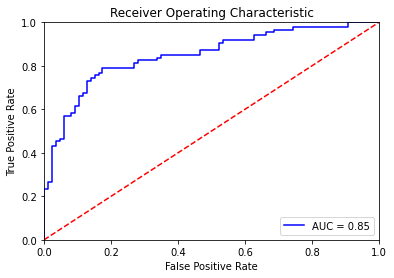

In [31]:
# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [32]:
# # Get predictions from the probabilities
# preds = np.argmax(probs, axis = 1)

# Get predictions from the probabilities
threshold = best_threshold
preds = np.where(probs[:, 1] >= threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of posts predicted non-negative: ", preds.sum())

Number of posts predicted non-negative:  83


In [33]:
from sklearn.metrics import classification_report
# preds = np.argmax(preds, axis = 1)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        86
           1       0.82      0.79      0.80        86

    accuracy                           0.81       172
   macro avg       0.81      0.81      0.81       172
weighted avg       0.81      0.81      0.81       172



In [34]:
print('Incorrect negative predictions:\n--------------------')
for sent in X_val[(preds==0) & (y_val.values==1)]:
  print(sent)
print()
print('Incorrect positive predictions:\n--------------------')
for sent in X_val[(preds==1) & (y_val.values==0)]:
  print(sent)

Incorrect negative predictions:
--------------------
So staying up late was worth it ... :sleepy_face: :weary_face:
Joey the genius ! I wish i was as brainy as him #towie
Does anyone not know Prince Harry got engaged ? I do n't think there 's been enough in the news about it .
Great night last night ! Muggins here is the commis chef crouched down in the corner . Seriously an honour to help raise money for @USER and work alongside these stellar chefs . Thanks for having us @USER @USER ! HTTPURL HTTPURL
It was the jerseys
Why would Alexa 's recipe for Yorkshire pudding be a bhaji yorkshire pudding ? ? @USER
@USER Sounds like a strong contender for GOTY
finished the queen 's gambit , i loved a look into the 1960s in the american south with no racism just vibes
rewatching degrassi for the millionth time
@USER you can copy mine
So my Twitter feed has to show me what tweets people I follow like . ... :neutral_face: If I unfollowed you , just know I 'm tired of seeing porn
Fav this and I wo n

# Evaluation on test set

In [35]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

In [36]:
# recalculate the best threshold for postive class F1 to prevent rounding differences

# get positive probs only to calculate best threshold for positive f1
pos_probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)

# calculate f1 for the positive class, ignore divide by zero warnings
with np.errstate(invalid='ignore'):
  pos_f1_score = (2 * precision * recall) / (precision + recall)

# retrieve the best threshold for the best positive f1 score
ix = np.argmax(np.nan_to_num(pos_f1_score))
best_threshold = thresholds[ix]
print('Best threshold:', best_threshold)

Best threshold: 0.99414283


In [37]:
# Get predictions from the probabilities
threshold = best_threshold
preds = np.where(probs[:, 1] >= threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of posts predicted non-negative: ", preds.sum())

Number of posts predicted non-negative:  204


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1200
           1       0.58      0.59      0.58       200

    accuracy                           0.88      1400
   macro avg       0.75      0.76      0.76      1400
weighted avg       0.88      0.88      0.88      1400



In [39]:
print('Incorrect negative predictions:\n--------------------')
for sent in X_test[(preds==0) & (y_test.values==1)]:
  print(sent)
print()
print('Incorrect positive predictions:\n--------------------')
for sent in X_test[(preds==1) & (y_test.values==0)]:
  print(sent)

Incorrect negative predictions:
--------------------
Sometimes I lay in bed and think about how today will be the day I make my life better . Exercise , drinking water , eating healthy . Then I wake up .
Max Verstappen is such a clean driver , he never makes dirty moves when racing .
Boris looked so statesman-like in that public address
I 'm soo excited to cook a three course Christmas dinner for my whole family this year !
if you listen carefully , you can hear me not carig
The Spanish National Ballet company rehearsing wearing masks : gasping , falling about clutching their chests unable to breathe after 2 minutes . Makes sense that you 'd refuse to wear a mask in a bus for five minutes to protect others . Totally . Carry on .
Been looking forward to today all weekend . Mondays are the best . I feel fresh and ready to start the week . SAID NO ONE EVER ! !
Politics is like waves , they depend on the wind where it blows
There are a bazillion things to do in my small town of Wadsworth .

# Save model to file

In [40]:
# torch.save(bert_classifier, 'bertweet_large_model.pth')

In [41]:
# !tar -czvf "bertweet_large_model.tar.gz" "bertweet_large_model.pth"

In [42]:
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)